In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import joblib

In [3]:
# Функция для векторизации текстовых данных
def vectorising(train_data, test_data, ngram_range=(2, 5)):
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, max_features=len(train_data))
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)
    return X_train_tfidf, X_test_tfidf, vectorizer

In [4]:
# Функция для печати результатов
def printRes(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [5]:
# Функция для взятия подвыборки из каждого подкласса
def sample_subclasses(df, n):
    # Группировка по подклассу и взятие n элементов из каждой группы
    sampled_df = df.groupby('subclass').apply(lambda x: x.sample(n=n, random_state=42)).reset_index(drop=True)
    return sampled_df

In [6]:
def svot_table(y_test_sub, y_pred_rf_sub):
    # Создание DataFrame для сравнения предсказаний с исходными значениями
    result_df = pd.DataFrame({
        'Original Subclass': label_encoder.inverse_transform(y_test_sub),
        'Predicted Subclass': label_encoder.inverse_transform(y_pred_rf_sub)
    })

    # Агрегирование данных для построения диаграмм
    comparison = result_df.groupby(['Original Subclass', 'Predicted Subclass']).size().unstack(fill_value=0)

    # Построение столбчатых диаграмм
    comparison.plot(kind='bar', stacked=True, figsize=(14, 8))
    plt.xlabel('Original Subclass')
    plt.ylabel('Number of Predictions')
    plt.title('Comparison of Original and Predicted Subclasses')
    plt.legend(title='Predicted Subclass', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [33]:
# Чтение данных
df = pd.read_csv('/kaggle/input/dga-dataset/dga_data.csv')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   isDGA     160000 non-null  object
 1   domain    159998 non-null  object
 2   host      160000 non-null  object
 3   subclass  160000 non-null  object
dtypes: object(4)
memory usage: 4.9+ MB
None


,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker
...,...,...,...,...
159995,legit,manhunt,manhunt.net,alexa
159996,legit,yupptv,yupptv.com,alexa
159997,legit,bbcmundo,bbcmundo.com,legit
159998,legit,kanogames,kanogames.com,legit


In [34]:
df = df.dropna()
df.loc[:, 'isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df1 = df.copy()
df1['subclass'].value_counts()

subclass
alexa           42614
legit           37384
cryptolocker    37254
newgoz           9276
gameoverdga      8461
nivdort          8456
necurs           8331
goz              6136
bamital          2086
Name: count, dtype: int64

In [35]:
label_encoder = LabelEncoder()
df1['subclass'] = label_encoder.fit_transform(df1['subclass'])
df1

,isDGA,domain,host,subclass
0,1,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,3
1,1,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,2
2,1,xxmamopyipbfpk,xxmamopyipbfpk.ru,2
3,1,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,7
4,1,jpqftymiuver,jpqftymiuver.ru,2
...,...,...,...,...
159995,0,manhunt,manhunt.net,0
159996,0,yupptv,yupptv.com,0
159997,0,bbcmundo,bbcmundo.com,5
159998,0,kanogames,kanogames.com,5


In [36]:
subclasses = [3, 4, 7]

# Выборка по 10 строк для каждого подкласса
sampled_dfs = {subclass: df1[df1['subclass'] == subclass].head(10) for subclass in subclasses}

# Вывод по 10 строк для каждого подкласса
for subclass, sampled_df in sampled_dfs.items():
    print(f"\nSubclass: {subclass}")
    print(sampled_df['host'])


Subclass: 3
0      6xzxsw3sokvg1tc752y1a6p0af.com
18        1rw1pc44mkxp4qjx18qua26.net
21    1x75xo41t4fno51wc86e1y4s13d.net
23      1y6oppp7k3pwfpo2sfmkloyxa.biz
30      1t5fkef5u26di8wtme9ezjamn.com
35     14ua4ir7rwqzv15mes59zpel1a.net
36    130qnn0srp6su1bosz2z19gx1a7.net
46      1y363y8izjhuol3ym91wdpdqr.biz
48    x3rv4x124bm7s1ik7tqi1tiwojo.biz
49    10z55t9lizwjo1ymilos13w3q69.com
Name: host, dtype: object

Subclass: 4
13           rcdqeqmpxgdiuqombhuwcfu.ru
52           jrxrovxkbemgqutopblbbfe.ru
55        dixnzhelzukwsojfxuivlamadu.ru
84       ydhmbyhgypnkdpzcymnnjxcalfm.ru
92         umficyzdvcdpzbalvdmkjjvcm.ru
95        ztscylhitkplaemfiuxcubozmr.ru
122    hmlzvbopfkrgaztrsdexgjbgageon.ru
126      pfvttkzllvxnvgiobbejbayuolj.ru
134       lrnbqspjuuchnflvovrtolvpvy.ru
141      qcrcnzfmxcaqtfyjzcypscdxtts.ru
Name: host, dtype: object

Subclass: 7
3       zfd5szpi18i85wj9uy13l69rg.net
7       mzapiwbcsbqiyxnlxa1hprx8n.com
17      n3m4txqpb6a415iwzkrmdzgk6.com
37    wawft814u

In [37]:
# Объединение подклассов
df['subclass'] = df['subclass'].replace({
    'alexa': 'alexa/legit',
    'legit': 'alexa/legit',
    'gameoverdga': 'newgoz'
})
# Проверка результатов
print(df['subclass'].value_counts())
df['subclass'] = label_encoder.fit_transform(df['subclass'])
df

subclass
alexa/legit     79998
cryptolocker    37254
newgoz          17737
nivdort          8456
necurs           8331
goz              6136
bamital          2086
Name: count, dtype: int64


/tmp/ipykernel_33/1505906909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subclass'] = df['subclass'].replace({
/tmp/ipykernel_33/1505906909.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subclass'] = label_encoder.fit_transform(df['subclass'])


,isDGA,domain,host,subclass
0,1,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,5
1,1,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,2
2,1,xxmamopyipbfpk,xxmamopyipbfpk.ru,2
3,1,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,5
4,1,jpqftymiuver,jpqftymiuver.ru,2
...,...,...,...,...
159995,0,manhunt,manhunt.net,0
159996,0,yupptv,yupptv.com,0
159997,0,bbcmundo,bbcmundo.com,0
159998,0,kanogames,kanogames.com,0


In [38]:
sampled_df = df.groupby('subclass', group_keys=False).apply(lambda x: x.sample(n=2000, random_state=42))
# Проверка результатов
sampled_df['subclass'].value_counts()

/tmp/ipykernel_33/591346324.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('subclass', group_keys=False).apply(lambda x: x.sample(n=2000, random_state=42))


subclass
0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
Name: count, dtype: int64

In [65]:
# Извлечение признаков и целевой переменной
X = df['host']
y = df['isDGA']
y = pd.to_numeric(y, downcast='integer')
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Векторизация данных
X_train_tfidf, X_test_tfidf, vectorizer1 = vectorising(X_train, X_test)

In [45]:
vectorizer1

TfidfVectorizer(analyzer='char', max_features=127998, ngram_range=(2, 5))

Accuracy: 0.9746875
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     16123
           1       0.98      0.96      0.97     15877

    accuracy                           0.97     32000
   macro avg       0.97      0.97      0.97     32000
weighted avg       0.97      0.97      0.97     32000



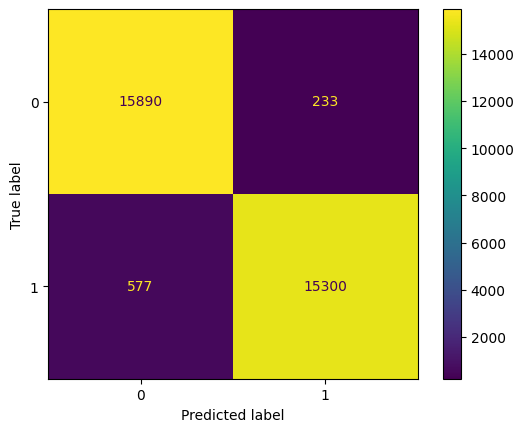

In [66]:
# Обучение модели
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)
# Предсказание и оценка модели
y_pred_rf = model_rf.predict(X_test_tfidf)
printRes(y_test, y_pred_rf)

Accuracy: 0.92146875
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     16123
           1       0.91      0.93      0.92     15877

    accuracy                           0.92     32000
   macro avg       0.92      0.92      0.92     32000
weighted avg       0.92      0.92      0.92     32000



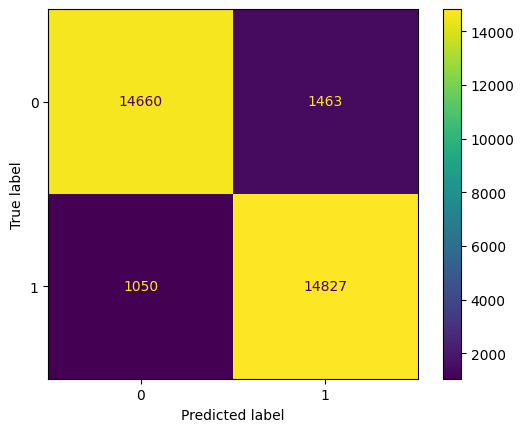

In [67]:
# Обучение модели
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb.fit(X_train_tfidf1, y_train)

# Предсказание и оценка модели
y_pred_gb = model_gb.predict(X_test_tfidf1)
printRes(y_test, y_pred_gb)

Accuracy: 0.936875
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     16123
           1       0.94      0.93      0.94     15877

    accuracy                           0.94     32000
   macro avg       0.94      0.94      0.94     32000
weighted avg       0.94      0.94      0.94     32000



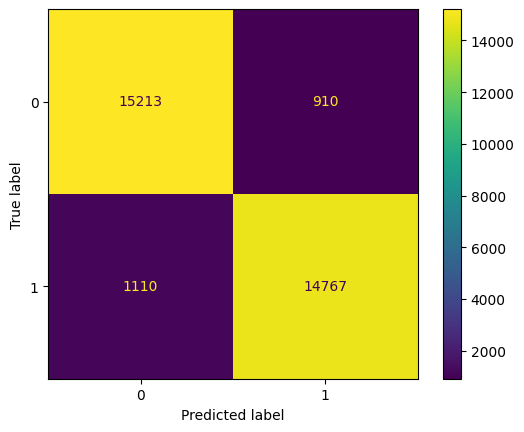

In [68]:
# Обучение модели
model_ada = AdaBoostClassifier(n_estimators=100, random_state=42)
model_ada.fit(X_train_tfidf1, y_train)

# Предсказание и оценка модели
y_pred_ada = model_ada.predict(X_test_tfidf1)
printRes(y_test, y_pred_ada)

In [69]:
joblib.dump(model_rf, "model_dga_detect_rf.pkl")
joblib.dump(model_gb, "model_dga_detect_gb.pkl")
joblib.dump(model_ada, "model_dga_detect_ada.pkl")
joblib.dump(vectorizer1, "vectorizer_dga_detect_gram2-5.pkl")

['vectorizer_dga_detect_gram2-5.pkl']

In [75]:
# Извлечение признаков и целевой переменной
X = sampled_df['host']  # Можно также добавить 'host' или другие текстовые поля
y = sampled_df['subclass']
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train_sub, y_test_sub = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Векторизация данных
X_train_tfidf, X_test_tfidf, vectorizer = vectorising(X_train, X_test)

Accuracy: 0.9346428571428571
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       407
           1       1.00      1.00      1.00       398
           2       0.85      0.93      0.89       402
           3       0.99      0.96      0.98       396
           4       0.90      0.89      0.89       418
           5       0.98      0.96      0.97       386
           6       0.93      1.00      0.96       393

    accuracy                           0.93      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.93      0.93      2800



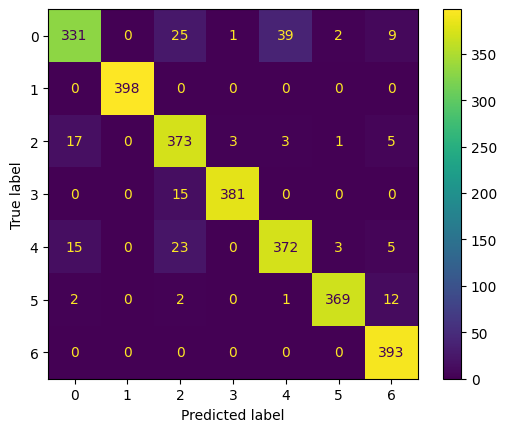

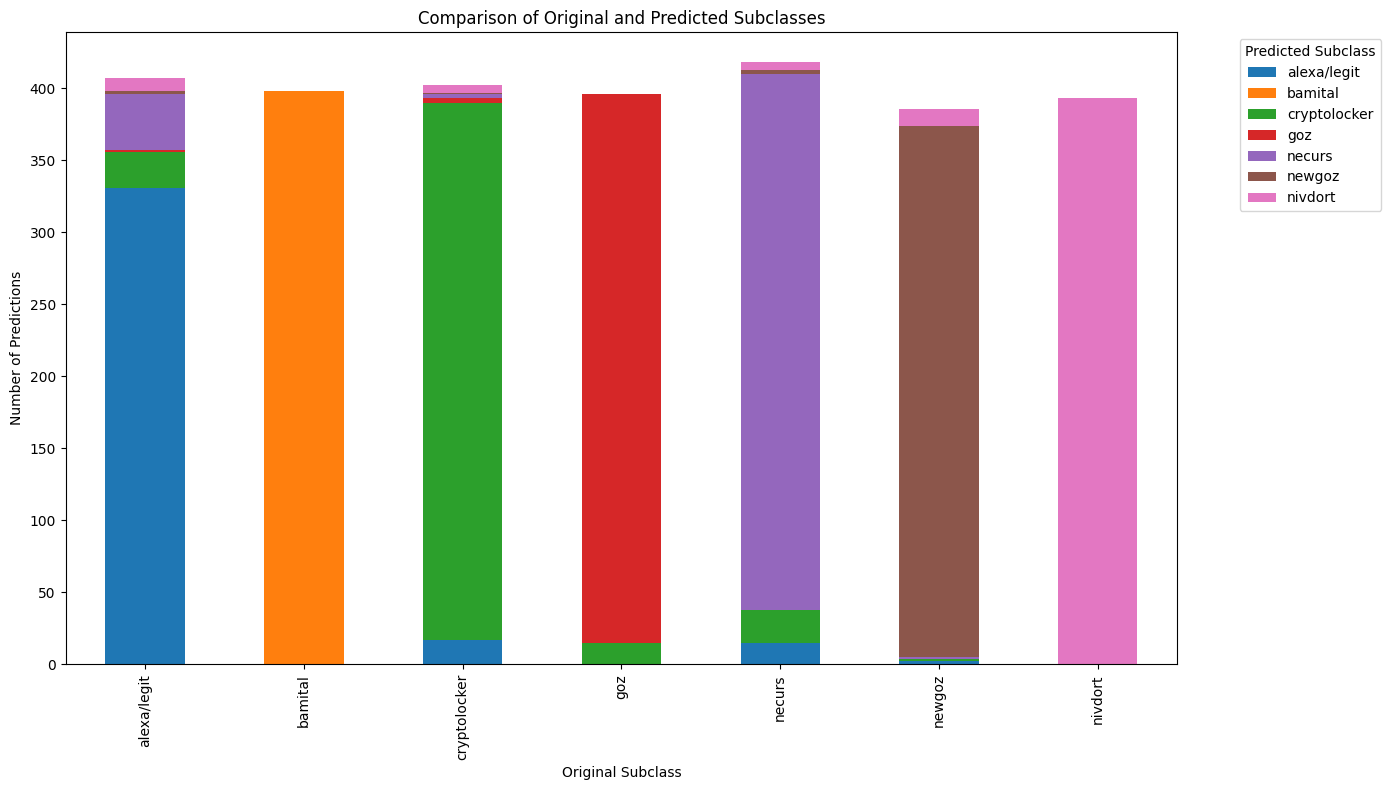

In [77]:
# Обучение модели
model_rf_sub = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_sub.fit(X_train_tfidf, y_train_sub)

# Предсказание и оценка модели
y_pred_rf_sub = model_rf_sub.predict(X_test_tfidf)
printRes(y_test_sub, y_pred_rf_sub)
svot_table(y_test_sub, y_pred_rf_sub)

Accuracy: 0.9296428571428571
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       407
           1       1.00      1.00      1.00       398
           2       0.85      0.92      0.89       402
           3       0.99      0.96      0.97       396
           4       0.89      0.89      0.89       418
           5       0.99      0.92      0.96       386
           6       0.91      0.99      0.95       393

    accuracy                           0.93      2800
   macro avg       0.93      0.93      0.93      2800
weighted avg       0.93      0.93      0.93      2800



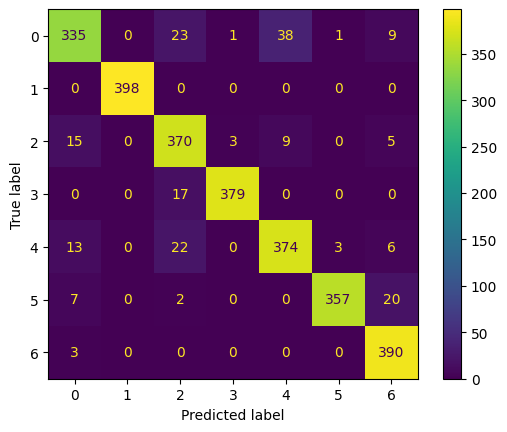

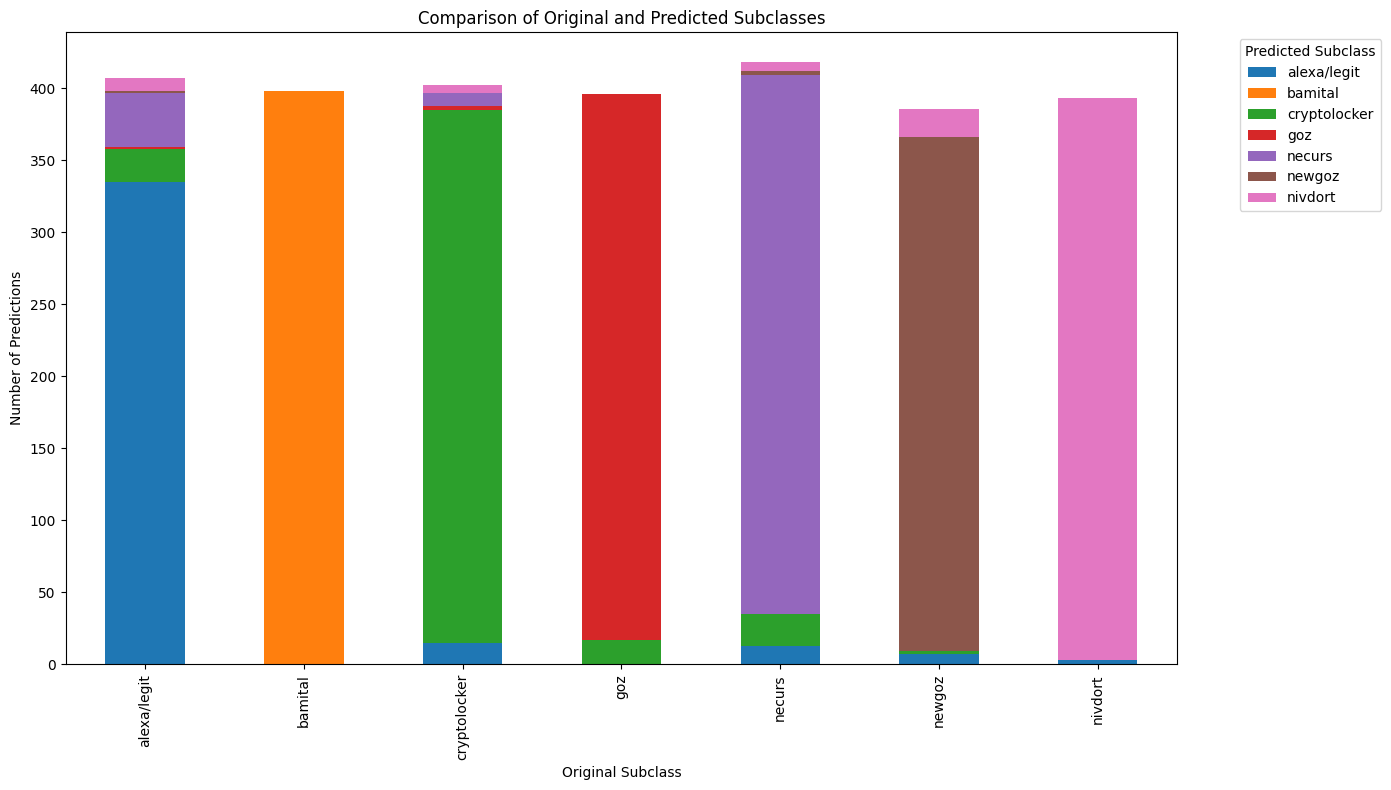

In [78]:
model_gb_sub = GradientBoostingClassifier(n_estimators=100, random_state=42)
model_gb_sub.fit(X_train_tfidf, y_train_sub)

# Предсказание и оценка модели
y_pred_gb_sub = model_gb_sub.predict(X_test_tfidf)
printRes(y_test_sub, y_pred_gb_sub)
svot_table(y_test_sub, y_pred_gb_sub)

Accuracy: 0.9489285714285715
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       407
           1       0.99      1.00      1.00       398
           2       0.92      0.90      0.91       402
           3       0.98      1.00      0.99       396
           4       0.91      0.91      0.91       418
           5       0.97      0.99      0.98       386
           6       0.92      1.00      0.96       393

    accuracy                           0.95      2800
   macro avg       0.95      0.95      0.95      2800
weighted avg       0.95      0.95      0.95      2800



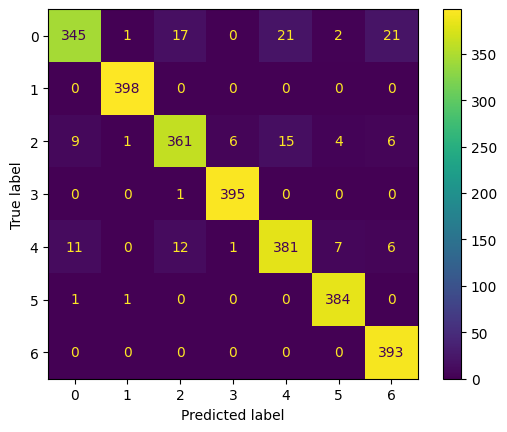

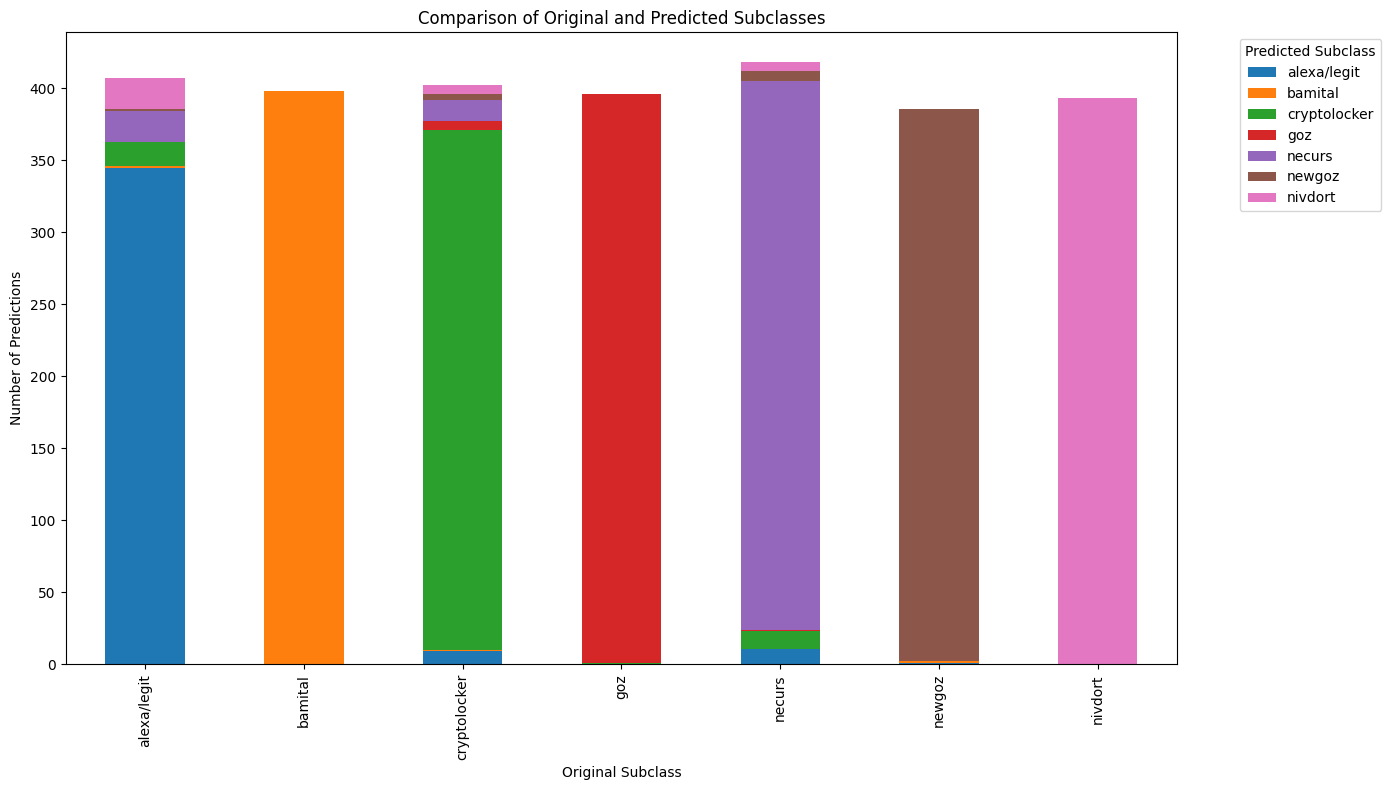

In [79]:
model_log_sub = LogisticRegression(max_iter=1000, random_state=42)
model_log_sub.fit(X_train_tfidf, y_train_sub)

# Предсказание и оценка модели
y_pred_log_sub = model_log_sub.predict(X_test_tfidf)
printRes(y_test_sub, y_pred_log_sub)
svot_table(y_test_sub, y_pred_log_sub)

In [80]:
joblib.dump(label_encoder, "label_encoder_sub.pkl")
joblib.dump(model_rf_sub, "model_rf_dga_sub.pkl")
joblib.dump(model_gb_sub, "model_gb_dga_sub.pkl")
joblib.dump(y_pred_log_sub, "model_log_dga_sub.pkl")
joblib.dump(vectorizer, "vectorizer_dga_sub_gram2-5.pkl")

['vectorizer_dga_sub_gram2-5.pkl']

In [81]:
df_val = pd.read_csv('/kaggle/input/validating-time/validatingWithTime.csv')

Accuracy: 0.9168085623935782
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     17123
           1       0.97      0.87      0.92     19876

    accuracy                           0.92     36999
   macro avg       0.92      0.92      0.92     36999
weighted avg       0.92      0.92      0.92     36999



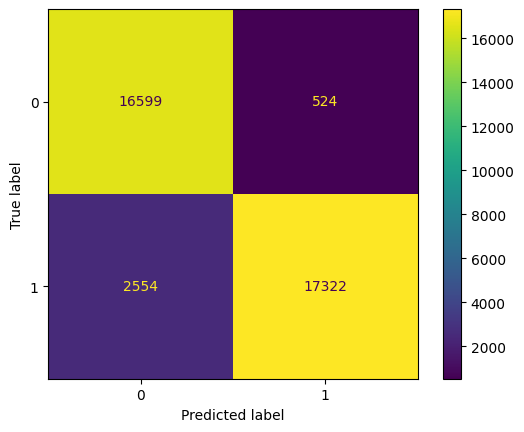

In [82]:
x_val = df_val['Query']
x_val = vectorizer1.transform(x_val)
y_pred_val = model_rf.predict(x_val)
printRes(df_val['Target'], y_pred_val)

In [83]:
from collections import Counter
x_val_sub = df_val['Query']
x_val_sub = vectorizer.transform(x_val_sub)
# Получение предсказаний
y_pred_val = model_log_sub.predict(x_val_sub)
# Преобразование предсказаний обратно в метки
y_pred_labels = label_encoder.inverse_transform(y_pred_val)

# Подсчет количества каждого предсказания
prediction_counts = Counter(y_pred_labels)

# Преобразование в словарь
prediction_dict = dict(prediction_counts)

print(prediction_dict)

{'newgoz': 5880, 'cryptolocker': 5729, 'alexa/legit': 16492, 'necurs': 4079, 'goz': 2262, 'nivdort': 2109, 'bamital': 448}
